In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Image
import os
%matplotlib inline

## SegmentNode Class

In [2]:
# TreeNode class to hold the data
# val : interpolated value of region
class TreeNode:
    def __init__(self,top,bot,left,right,save_dir='forecasting'):
        # parameters of specific node
        self.top = top 
        self.bot = bot
        self.left = left
        self.right = right
        
        # 4 children here
        self.top_left = None
        self.top_right = None
        self.bot_left = None
        self.bot_right = None
        
        self.save_dir = save_dir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        self.node_dir = 'node_' + str(self.top) + '_' + str(self.bot) + '_' + str(self.left) + '_' + str(self.right)
        self.node_dir = os.path.join(self.save_dir,self.node_dir)
        if not os.path.exists(self.node_dir):
            os.mkdir(self.node_dir)
        
        self.tested = False
        
    def standardize(self,x):     
        x_min = np.min(x,axis=(3,4),keepdims=True)
        x_max = np.max(x,axis=(3,4),keepdims=True)
        x = (x - x_min) / (x_max + 1E-15)
        return x,x_min,x_max
        
    def numChildren(self):
        num_children = 0
        for child in (self.top_left,self.top_right,self.bot_left,self.bot_right):
            if child:
                num_children += 1
        return num_children        
    
    def getChildren(self):
        children = []
        for child in (self.top_left,self.top_right,self.bot_left,self.bot_right):
            if child:
                children.append(child)
        return children
    
    def makeAutoEncoder(self,x,prev_residual):
        x_standardized,_,_ = self.standardize(x)
        batches,time_steps,chans,rows,cols = x_standardized.shape
        
        batches,self.pred_time_steps,self.y_chans,self.y_rows,self.y_cols = prev_residual.shape
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        y_lims = [self.top,self.bot,self.left,self.right]
        self.encoder_model = convLSTM_AE_Model(x_standardized,prev_residual,self.node_dir,y_lims,self.device)
        
    def trainAutoEncoder(self):    
        self.encoder_model.train()
        
    def testAutoEncoder(self,test_data):    
        test_data_standardized,_,_ = self.standardize(test_data)
        batches,time_steps,chans,rows,cols = test_data_standardized.shape
        
        self.encoder_model.model = torch.load(os.path.join(self.node_dir,'model.pth')).to(self.device)
        
        self.encoder_model.model.y_lims = [self.top,self.bot,self.left,self.right]
        self.encoder_model.model.eval()
        
        resid_reconstruction = None
        test_dataloader = DataLoader(torch.Tensor(test_data_standardized),shuffle=False,batch_size=2)
        y_lims = [self.top,self.bot,self.left,self.right]
        for test_batch in test_dataloader:
            batch_resid = self.encoder_model.model(test_batch.to(self.device),self.y_rows,self.y_cols,self.pred_time_steps)
            if resid_reconstruction is None:
                resid_reconstruction = batch_resid.detach().cpu().numpy()
            else:
                resid_reconstruction = np.concatenate([resid_reconstruction,batch_resid.detach().cpu().numpy()],axis=0)
        del self.encoder_model.model
        torch.cuda.empty_cache()
        self.tested = True
        return np.array(resid_reconstruction)
        
    def addChildren(self):
        h = self.bot - self.top
        w = self.right - self.left
        if w > 1 or h > 1:
            h_mid = self.left + math.ceil(w/2)
            v_mid = self.top + math.ceil(h/2)
            sub_h_mid = math.ceil(w/2)
            sub_v_mid = math.ceil(h/2)

            if w == 1:
                self.top_left = TreeNode(self.top,v_mid,self.left,h_mid)
                self.bot_left = TreeNode(v_mid,self.bot,self.left,h_mid)
            elif h == 1:
                self.top_left = TreeNode(self.top,v_mid,self.left,h_mid)
                self.top_right = TreeNode(self.top,v_mid,h_mid,self.right)
            else:    
                self.top_left = TreeNode(self.top,v_mid,self.left,h_mid)
                self.top_right = TreeNode(self.top,v_mid,h_mid,self.right)
                self.bot_left = TreeNode(v_mid,self.bot,self.left,h_mid)
                self.bot_right = TreeNode(v_mid,self.bot,h_mid,self.right)
    
    def getBounds(self,p=False):
        bounds = [self.top,self.bot,self.left,self.right]
        if p:
            print('node(top,bot,left,right) : node({})'.format(bounds))
        else:    
            return bounds
              
    def getNodeData(self,p=False):
        if p:
            print('self.x.shape : {}'.format(self.x.shape))
            print('self.prev_residual.shape : {}'.format(self.prev_residual.shape))
            if self.tested:
                print('self.curr_residual.shape : {}'.format(self.curr_residual.shape))
                print('self.resid_reconstruction.shape : {}'.format(self.resid_reconstruction.shape))
        else:    
            if self.tested:
                return self.x, self.prev_residual, self.curr_residual, self.resid_reconstruction
            else:
                return self.x, self.prev_residual

## Autoencoder Model + Training Setup

### Taking ConvLSTM from https://holmdk.github.io/2020/04/02/video_prediction.html

In [3]:
# This is a seq-seq implementation
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [4]:
class EncoderDecoderConvLSTM(nn.Module):
    def __init__(self, nf, in_chan, x_rows, x_cols, y_rows, y_cols, y_lims):
        super(EncoderDecoderConvLSTM, self).__init__()

        """ ARCHITECTURE 

        # Encoder (ConvLSTM)
        # Encoder Vector (final hidden state of encoder)
        # Decoder (ConvLSTM) - takes Encoder Vector as input
        # Decoder (3D CNN) - produces regression predictions for our model

        """
        self.encoder_1_convlstm = ConvLSTMCell(input_dim=in_chan,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.encoder_2_convlstm = ConvLSTMCell(input_dim=nf,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)
        
        #self.encoder_to_decoder = nn.Linear(nf*x_rows*x_cols,nf*y_rows*y_cols)
        
        self.decoder_1_convlstm = ConvLSTMCell(input_dim=nf,  # nf + 1
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_2_convlstm = ConvLSTMCell(input_dim=nf,
                                               hidden_dim=nf,
                                               kernel_size=(3, 3),
                                               bias=True)

        self.decoder_CNN = nn.Conv3d(in_channels=nf,
                                     out_channels=1,
                                     kernel_size=(1, 3, 3),
                                     padding=(0, 1, 1))
        self.y_lims = y_lims


    def autoencoder(self, x, seq_len, future_step, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4):

        outputs = []

        # encoder
        for t in range(seq_len):
            h_t, c_t = self.encoder_1_convlstm(input_tensor=x[:, t, :, :],
                                               cur_state=[h_t, c_t])  # we could concat to provide skip conn here
            h_t2, c_t2 = self.encoder_2_convlstm(input_tensor=h_t,
                                                 cur_state=[h_t2, c_t2])  # we could concat to provide skip conn here

        # encoder_vector
        encoder_vector = h_t2
        
        #b, _, _, _, _ = x.size()
        #b, out_steps, chans, y_rows, y_cols = x.size()
        #encoded_reshaped = encoder_vector.view((b,-1))
        #decoder_input = self.encoder_to_decoder(encoded_reshaped)
        #decoder_input = decoder_input.view((b,out_steps,-1,y_rows,y_cols))
        
        # TODO I want to add a transformer layer to to include global attention to the network for different regions!
        
        rs,re,hs,he = self.y_lims
        decoder_input = encoder_vector[:,:,rs:re,hs:he]

        # decoder
        for t in range(future_step):
            h_t3, c_t3 = self.decoder_1_convlstm(input_tensor=decoder_input,
                                                 cur_state=[h_t3, c_t3])  # we could concat to provide skip conn here
            h_t4, c_t4 = self.decoder_2_convlstm(input_tensor=h_t3,
                                                 cur_state=[h_t4, c_t4])  # we could concat to provide skip conn here
            encoder_vector = h_t4
            outputs += [h_t4]  # predictions

        outputs = torch.stack(outputs, 1)
        outputs = outputs.permute(0, 2, 1, 3, 4)
        outputs = self.decoder_CNN(outputs)
        outputs = outputs.permute(0,2,1,3,4)
        #outputs = torch.nn.Sigmoid()(outputs)

        return outputs

    def forward(self, x, y_rows, y_cols, future_seq=0, hidden_state=None):

        """
        Parameters
        ----------
        input_tensor:
            5-D Tensor of shape (b, t, c, h, w)        #   batch, time, channel, height, width
        """

        # find size of different input dimensions
        b, seq_len, _, h, w = x.size()

        # initialize hidden states
        h_t, c_t = self.encoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t2, c_t2 = self.encoder_2_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t3, c_t3 = self.decoder_1_convlstm.init_hidden(batch_size=b, image_size=(y_rows, y_cols))
        h_t4, c_t4 = self.decoder_2_convlstm.init_hidden(batch_size=b, image_size=(y_rows, y_cols))

        # autoencoder forward
        outputs = self.autoencoder(x, seq_len, future_seq, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4)

        return outputs

In [5]:
class convLSTM_AE_Model:
    
    def __init__(self,x,y,node_dir,y_lims,device='cuda:0'):
        super(convLSTM_AE_Model,self).__init__()
        tensor_x = torch.Tensor(x)
        tensor_y = torch.Tensor(y)
        torch_dataset = TensorDataset(tensor_x,tensor_y)
        self.train_dataloader = DataLoader(torch_dataset,shuffle=True,batch_size=2)
        self.node_dir = node_dir
        self.device = device
        y_lims = y_lims
        
        samples,in_time_steps,in_chans,rows,cols = x.shape
        input_shape = [samples,in_time_steps,in_chans,rows,cols]
        batches,out_time_steps,out_chans,self.y_rows,self.y_cols = y.shape
        output_shape = [samples,out_time_steps,out_chans,self.y_rows,self.y_cols]
        self.out_time_steps = out_time_steps
        self.model = EncoderDecoderConvLSTM(32,in_chans,rows,cols,self.y_rows,self.y_cols,y_lims).to(device)
        
        
    def forward(self,x):
        output = self.model(x,self.y_rows,self.y_cols,future_seq=self.out_time_steps)
        return output
    
    def train(self,epochs=2):
        
        self.loss_fn = torch.nn.MSELoss().to(self.device)
        learning_rate = 1e-4    
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=learning_rate)
        
        for epoch in range(epochs):
            for data in self.train_dataloader:
                x,y = data
                #y = y.squeeze()
                
                #y_pred = self.forward(x.cuda()).squeeze()
                #loss = self.loss_fn(y_pred,y.cuda())
                #y_pred = self.forward(x).squeeze()
                y_pred = self.forward(x.to(self.device))
                loss = self.loss_fn(y_pred,y.to(self.device))

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            #if epoch % 100 == 99:
            print('\t\tEpoch {}\t Loss : {}'.format(epoch, loss.item()))
        torch.save(self.model,os.path.join(self.node_dir,'model.pth'))
        del self.model
        del self.loss_fn
        torch.cuda.empty_cache()

## Loading Data & Building Segment Tree (Forecasting)

In [6]:
data = np.load('marsigli_flow.npy')
print('data.shape :',data.shape)
samples,bot,right = data.shape
    
time_len_in = 4
time_len_pred = 3
total_time = time_len_in + time_len_pred
time_samples = samples - total_time
time_data = np.zeros((time_samples,total_time,1,bot,right))
for t in range(time_samples):
    time_data[t,:,0,:,:] = data[t:t+total_time]

random_seed = 1234
np.random.seed(random_seed)
randomized_idx = np.random.permutation(time_samples)

train_idx = randomized_idx[:int(0.75*time_samples)]
val_idx = randomized_idx[int(0.75*time_samples):]

train_data = time_data[train_idx]
train_labels = train_data[:,-time_len_pred:,:,:]
train_data = train_data[:,:time_len_in,:,:]
val_data = time_data[val_idx]
val_labels = val_data[:,-time_len_pred:,:,:]
val_data = val_data[:,:time_len_in,:,:]
print('train_data.shape :',train_data.shape)
print('train_labels.shape :',train_labels.shape)
print('val_data.shape :',val_data.shape)
print('val_labels.shape :',val_labels.shape)

save_dir = 'forecasting'
seg_nodes = [[-1,TreeNode(0,bot,0,right,save_dir)]]

# reconstruction_record holds the reconstructed image at each layer
training_reconstruction_record = [np.zeros(train_labels.shape)]
testing_reconstruction_record = [np.zeros(val_labels.shape)]
# region_record holds the boundaries of each segment used at each layer
region_record = [[[0,bot,0,right]]]

data.shape : (201, 64, 512)
train_data.shape : (145, 4, 1, 64, 512)
train_labels.shape : (145, 3, 1, 64, 512)
val_data.shape : (49, 4, 1, 64, 512)
val_labels.shape : (49, 3, 1, 64, 512)


## Running Autoencoder

In [7]:
# Start with the broadest autoencoder (whole dataset)
# Each node represents one autoencoder of one region of the image
# Iteratively replace the worse node with its children nodes
# for the desired number of levels or until the overall reconstruction error is under the mse_threshold

max_levels = 5
levels_used = 0
mse_threshold = 0.01 

for level in range(max_levels):
    print('\nAUTOENCODER LEVEL {}'.format(level))
    # Add residual reconstruction to previous reconstruction
    training_reconstruction_record.append(training_reconstruction_record[level].copy())
    testing_reconstruction_record.append(testing_reconstruction_record[level].copy())
    region_record.append([])
    levels_used += 1
    
    for i,region in enumerate(seg_nodes):
        mse, node = region
        if mse < 0:
            t,b,l,r = node.getBounds()
            print('\n\tNode(top,bot,left,right) : Node({},{},{},{})'.format(t,b,l,r))
            
            train_residual = train_labels[:,:,:,t:b,l:r] - training_reconstruction_record[level][:,:,:,t:b,l:r]
            node.makeAutoEncoder(train_data,train_residual)
            node.trainAutoEncoder()
            train_reconstruction = node.testAutoEncoder(train_data)
            test_reconstruction = node.testAutoEncoder(val_data)
            
            training_reconstruction_record[level+1][:,:,:,t:b,l:r] += train_reconstruction
            testing_reconstruction_record[level+1][:,:,:,t:b,l:r] += test_reconstruction
            
            # Use the TRAINING reconstruction loss to segment the autoencoder
            loss = np.mean(np.square(np.subtract(train_labels[:,:,:,t:b,l:r],training_reconstruction_record[level+1][:,:,:,t:b,l:r])))
            print('\tResidual reconstruction loss : {}'.format(loss))
            seg_nodes[i][0] = loss                          
            
    # Adds the currently used nodes into a list for visualization purposes later
    for i,region in enumerate(seg_nodes):
        mse, node = region
        t,b,l,r = node.getBounds()
        region_record[level+1].append([t,b,l,r])
        
    overall_reconstruction_mse = np.mean(np.square(np.subtract(train_labels,training_reconstruction_record[-1])))
    print('\n\tOverall reconstruction loss : {}'.format(overall_reconstruction_mse))
    if mse_threshold:
        if overall_reconstruction_mse < mse_threshold:
            break
    
    # replace the worst node with its children
    seg_nodes.sort(reverse=True,key=lambda x:x[0])
    subRegionFound = False
    while subRegionFound == False:
        mse,worst_node = seg_nodes.pop(0)
        worst_node.addChildren()
        
        children = worst_node.getChildren()
        
        if worst_node.numChildren() > 0:
            t,b,l,r = worst_node.getBounds()
            print('\tSegmenting Node({},{},{},{})\n'.format(t,b,l,r))
            subRegionFound = True
            
            for child in worst_node.getChildren():
                #child.getBounds(p=True)
                #child.getNodeData(p=True)
                seg_nodes.append([-1,child])


AUTOENCODER LEVEL 0

	Node(top,bot,left,right) : Node(0,64,0,512)
		Epoch 0	 Loss : 1.4397001266479492
		Epoch 1	 Loss : 1.2979182004928589
	Residual reconstruction loss : 1.1254442972733507

	Overall reconstruction loss : 1.1254442972733507
	Segmenting Node(0,64,0,512)


AUTOENCODER LEVEL 1

	Node(top,bot,left,right) : Node(0,32,0,256)
		Epoch 0	 Loss : 1.4760196208953857
		Epoch 1	 Loss : 0.44851383566856384
	Residual reconstruction loss : 1.4432483369746498

	Node(top,bot,left,right) : Node(0,32,256,512)
		Epoch 0	 Loss : 0.0614502839744091
		Epoch 1	 Loss : 1.0386478900909424
	Residual reconstruction loss : 0.3071215864801534

	Node(top,bot,left,right) : Node(32,64,0,256)
		Epoch 0	 Loss : 0.09305703639984131
		Epoch 1	 Loss : 2.0630650520324707
	Residual reconstruction loss : 0.3429755979206067

	Node(top,bot,left,right) : Node(32,64,256,512)
		Epoch 0	 Loss : 1.4618175029754639
		Epoch 1	 Loss : 1.345794916152954
	Residual reconstruction loss : 1.3902801573807042

	Overall recon

## Plotting Some Analysis/Results

MovieWriter imagemagick unavailable; using Pillow instead.


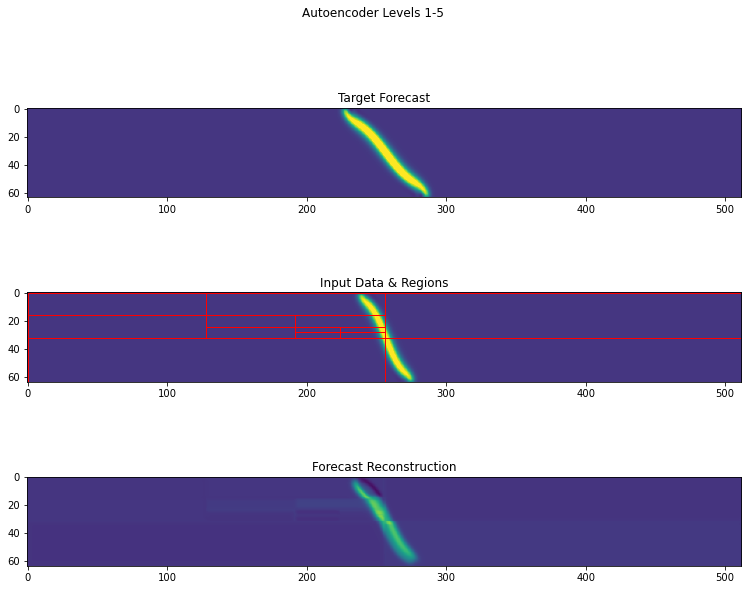

In [8]:
import matplotlib.animation as anim

class AnimatedGif:
    
    def __init__(self,vmin,vmax,size=(1280,960)):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / 100, size[1] / 100)
        self.ax0 = self.fig.add_subplot(311)
        self.ax1 = self.fig.add_subplot(312)
        self.ax2 = self.fig.add_subplot(313)
        self.images = []
        self.vmin = vmin
        self.vmax = vmax
        
    def add(self, oimg, in_regions, reconstruction, reg_record, lvl='' ):
        sup_title = self.fig.suptitle('Autoencoder Levels 1-'+lvl)
        ax311_title = self.ax0.set_title('Target Forecast')
        plt_img311 = self.ax0.imshow(oimg,vmin=self.vmin,vmax=self.vmax,animated=True)
        ax312_title = self.ax1.set_title('Input Data & Regions')
        plt_img312 = self.ax1.imshow(in_regions,vmin=self.vmin,vmax=self.vmax,animated=True)
        recs = []
        for region in reg_record:
            t,b,l,r = region
            h = b-t
            w = r-l
            rec = self.ax1.add_patch(patches.Rectangle((l,t),w,h,linewidth=1,edgecolor='r',facecolor='none'))
            recs.append(rec)
        ax313_title = self.ax2.set_title('Forecast Reconstruction')
        plt_img313 = self.ax2.imshow(reconstruction,vmin=self.vmin,vmax=self.vmax,animated=True)
        self.images.append([plt_img311,plt_img312,plt_img313,ax311_title,ax312_title,ax313_title,sup_title]+recs)
        
    def save(self, filename):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer='imagemagick', fps = 2)
        
batch_num = 0
in_time = 0
out_time = 2
# testing_reconstruction_record - (level,batches,time_steps,channels,rows,cols)
rec_record = np.array(testing_reconstruction_record)
animated_gif = AnimatedGif(np.min(rec_record),np.max(rec_record))

for i in range(1,levels_used+1):
    # val_labels is (batch,time_steps,channels,rows,cols)
    # rec_record is (level,batch,time_steps,channels,rows,cols)
    animated_gif.add(val_labels[batch_num,out_time,0],
                     val_data[batch_num,in_time,0], 
                     rec_record[i,batch_num,out_time,0], 
                     region_record[i], 
                     lvl=str(i))
animated_gif.save(os.path.join(save_dir,'segEncoder_forecasting.gif'))
Image(url=os.path.join(save_dir,'segEncoder_forecasting.gif'))

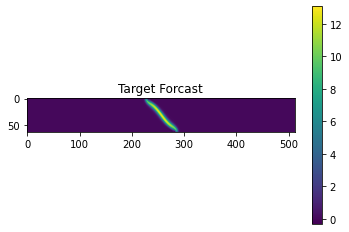

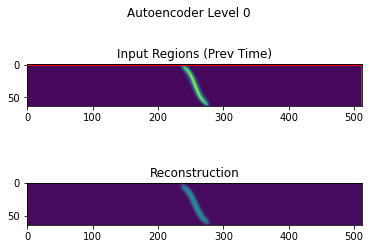

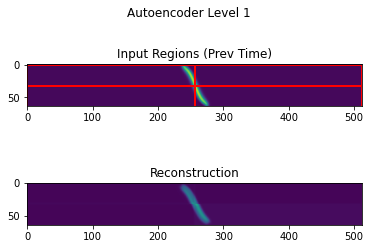

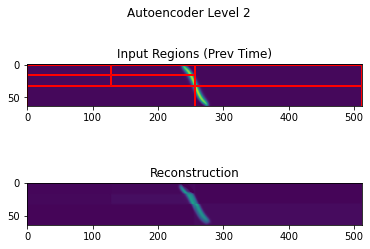

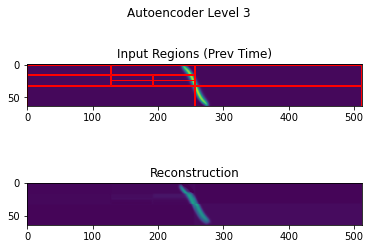

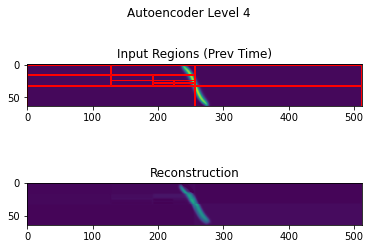

In [9]:
batch_num = 0
in_time = 0
out_time = 2

plt.figure(0)
plt.title('Target Forcast')
plt.imshow(val_labels[batch_num,out_time,0])
plt.colorbar()

for i in range(1,levels_used+1):
    plt.figure(i+1)
    plt.suptitle('Autoencoder Level {}'.format(i-1))
    plt.subplot(211)
    plt.title('Input Regions (Prev Time)')
    plt.imshow(val_data[batch_num,in_time,0])
    plt.clim(np.min(val_labels[batch_num,out_time,0]),np.max(val_labels[batch_num,out_time,0]))
    regions = region_record[i]
    for region in regions:
        t,b,l,r = region
        h = b-t
        w = r-l
        plt.gca().add_patch(patches.Rectangle((l,t),w-1,h-1,linewidth=1,edgecolor='r',facecolor='none'))
    plt.subplot(212)
    plt.title('Reconstruction')
    plt.imshow(testing_reconstruction_record[i][batch_num,out_time,0])
    plt.clim(np.min(val_labels[batch_num,out_time,0]),np.max(val_labels[batch_num,out_time,0]))

In [10]:
# This is my intial attempt at a convLSTM autoencoder

#class ConvBlock(nn.Module):
#    def __init__(self,conv_chans,kernel_size=3):
#        super(ConvBlock,self).__init__()
#        self.convs = nn.ModuleList()
#        for i in range(len(conv_chans)-1):
#            self.convs.append(
#                nn.Conv2d(conv_chans[i],conv_chans[i+1],kernel_size=kernel_size,stride=1,padding=1)
#            )
#            self.convs.append( nn.LeakyReLU() )
#    def forward(self,x): 
#        for layer in self.convs:
#            x = layer(x)
#        return x
#    
#class LSTMBlock(nn.Module):
#    def __init__(self,in_size,hidden_size):
#        super(LSTMBlock,self).__init__()
#        self.lstm1 = nn.LSTM(input_size=in_size,
#                    hidden_size=hidden_size,
#                    batch_first=True
#                   )
#        self.lstm2 = nn.LSTM(input_size=hidden_size,
#                    hidden_size=hidden_size,
#                    batch_first=True
#                   )
#        self.relu = nn.LeakyReLU()
#    def forward(self,x): 
#        x,hs = self.lstm1(x)
#        x = self.relu(x)
#        x,hs = self.lstm2(x)
#        x = self.relu(x)
#        return x
#    
#class MLPBlock(nn.Module):
#    def __init__(self,mlp_sizes):
#        super(MLPBlock,self).__init__()
#        self.mlps = nn.ModuleList()
#        for i in range(len(mlp_sizes)-1):
#            self.mlps.append(
#                nn.Linear(mlp_sizes[i],mlp_sizes[i+1]),
#            )
#            self.mlps.append( nn.LeakyReLU() )
#    def forward(self,x):
#        for layer in self.mlps:
#            x = layer(x)
#        return x
#    
#class Encoder(nn.Module):
#    def __init__(self,in_shape,conv_chans=[1,8,32],mlp_sizes=[32,8]):
#        super(Encoder,self).__init__()
#        samples, self.in_time_steps, self.rows, self.cols = in_shape
#        self.conv_chans = conv_chans
#        self.convEncoder = ConvBlock(conv_chans)
#        self.lstmEncoder = LSTMBlock(self.rows*self.cols*conv_chans[-1],conv_chans[-1])
#        self.mlpBlock = MLPBlock(mlp_sizes)
#    def forward(self,x):
#        self.samples = list(x.shape)[0]
#        x = x.view(self.samples*self.in_time_steps,1,self.rows,self.cols)
#        x = self.convEncoder(x)
#        x = x.view(self.samples,self.in_time_steps,self.rows*self.cols*self.conv_chans[-1])
#        x = self.lstmEncoder(x)
#        x = x.view(self.samples,self.in_time_steps,self.conv_chans[-1])
#        x = self.mlpBlock(x)
#        x = x.view(self.samples,-1)
#        # x = (samples,time_steps,latent_size)
#        return x
#    
#class Decoder(nn.Module):
#    def __init__(self,in_shape,out_shape,mlp_sizes=[8,32],conv_chans=[32,8]):
#        super(Decoder,self).__init__()
#        samples, self.out_time_steps, self.rows, self.cols = out_shape
#        self.in_time_steps = in_shape[1]
#        mlp_sizes = np.array(mlp_sizes)
#        self.conv_chans = conv_chans
#        # Linear layer if in and out time_steps are different
#        self.bottleneck = nn.Linear(self.in_time_steps*mlp_sizes[0],self.out_time_steps*mlp_sizes[0])
#        self.relu = nn.LeakyReLU()
#        self.mlpBlock = MLPBlock(mlp_sizes)
#        self.lstmDecoder = LSTMBlock(self.conv_chans[0],self.conv_chans[0])
#        self.convDecoder = ConvBlock(self.conv_chans)
#        self.outConv = nn.Conv2d(self.conv_chans[-1],1,kernel_size=1,stride=1)
#    def forward(self,x):
#        self.samples = list(x.shape)[0]
#        x = self.relu(self.bottleneck(x))
#        x = x.view(self.samples,self.out_time_steps,-1)
#        x = self.mlpBlock(x)
#        x = self.lstmDecoder(x)
#        x = x.reshape(self.samples*self.out_time_steps,self.conv_chans[0],1,1)
#        x = x.repeat((1,1,self.rows,self.cols))
#        x = x.view(self.samples*self.out_time_steps,self.conv_chans[0],self.rows,self.cols)
#        x = self.convDecoder(x)
#        x = self.outConv(x)
#        x = x.view(self.samples,self.out_time_steps,self.rows,self.cols)
#        return x
#
#class AE_Forecaster(torch.nn.Module):
#    
#    def __init__(self,input_shape,output_shape):
#        super(AE_Forecaster,self).__init__()
#        self.encoder = Encoder(input_shape)
#        self.decoder = Decoder(input_shape,output_shape)
#            
#    def forward(self, x):
#        encoded = self.encoder(x)
#        decoded = self.decoder(encoded)
#        return decoded

In [11]:
#class encoderModel:
#    
#    def __init__(self,x,y):
#        tensor_x = torch.Tensor(x)
#        tensor_y = torch.Tensor(y)
#        torch_dataset = TensorDataset(tensor_x,tensor_y)
#        self.train_dataloader = DataLoader(torch_dataset,shuffle=True,batch_size=1)
#        
#        samples,in_time_steps,rows,cols = x.shape
#        input_shape = [samples,in_time_steps,rows,cols]
#        batches,out_time_steps,y_rows,y_cols = y.shape
#        output_shape = [samples,out_time_steps,y_rows,y_cols]
#        self.model = AE_Forecaster(input_shape,output_shape)
#        
#        self.loss_fn = torch.nn.MSELoss(reduction='sum').cuda()
#        learning_rate = 1e-3    
#        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=learning_rate)
#    
#    def train(self,epochs=200):
#        self.losses = []
#        for epoch in range(epochs):
#            for data in self.train_dataloader:
#                x,y = data
#                x, y = x.cuda(), y.cuda()
#                
#                y_pred = self.model(x).cuda()
#                loss = self.loss_fn(y_pred,y)
#
#                self.optimizer.zero_grad()
#                loss.backward()
#                self.optimizer.step()
#
#            #if epoch % 100 == 99:
#            print('\t\tEpoch {}\t Loss : {}'.format(epoch, loss.item()))
#            self.losses.append(loss)

## ELM Class

In [12]:
class ELM:
    
    def __init__(self,x,y):
        self.x = x
        self.y = y
        n_hidden = 8
        samples,_ = self.x.shape
        self.w1 = np.random.random((n_hidden,samples))
        #self.w1 = np.repeat(self.w1,samples,axis=1)
        self.b1 = np.random.random((n_hidden,1))
        self.w2 = None
        
    def tanSigmoid(self,x):
        return (1 - np.exp(-2*x)) / (1 + np.exp(-2*x))
    
    def calcW2(self):
        hidden = self.tanSigmoid( np.matmul(self.w1,self.x) + self.b1 ).T
        hDagger = np.linalg.pinv(hidden)
        w2T = np.matmul(hDagger,self.y.T)
        self.w2 = w2T.T
        
    def predict(self,data_test):
        if self.w2 == None:
            self.calcW2()
            
        x1 = self.tanSigmoid( np.matmul(self.w1,data_test) + self.b1 )
        x2 = np.matmul(self.w2,x1)
        return x2